In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Questão 1)

In [2]:
df = np.genfromtxt("/content/drive/MyDrive/topicos avançados em ML/clustering_data.csv", delimiter = ',')

In [3]:
df.shape

(100, 2)

In [4]:
def media_e_desvio_padrao(dataset):

  media = np.mean(dataset, axis=0)
  desvio_padrao = np.std(dataset, axis=0)
  data = (dataset - media) / desvio_padrao

  return data, media, desvio_padrao

In [5]:
def normalizar_ponto(ponto, media, desvio_padrao):
  normal = ((ponto - media) / desvio_padrao)

  return normal

In [6]:
def k_means(dataset: np.array, k: int, seed: int):
  rng = np.random.default_rng(seed = seed)
  matriz = np.ndarray((k, dataset.shape[1]))
  matriz[0] = rng.choice(dataset)

  for i in range(1, k):
    d = np.ndarray((dataset.shape[0], i))
    for j in range(i):
      d[:, j] = np.apply_along_axis(func1d= lambda x: np.sqrt(np.sum((x-matriz[j])**2)), axis = 1, arr = dataset)
    min_d = np.min(d, axis = 1)
    min_d_normalizada = min_d/np.sum(min_d)
    matriz[i] = rng.choice(dataset, p = min_d_normalizada)

  while True:
    matriz_nova = matriz.copy()
    cluster = np.argmin(np.linalg.norm(dataset[:, np.newaxis] - matriz, axis=2), axis=1)
    matriz = np.array([np.mean(dataset[cluster == i], axis=0) for i in range(k)])

    variavel = np.mean(np.linalg.norm(matriz - matriz_nova, axis=1))
    if variavel <= 0.1:
        break

  erro = np.sum([(np.linalg.norm(dataset[cluster == i] - matriz[i])**2) for i in range(k)])

  return matriz, erro, cluster

In [11]:
def gmm(dataset, k):
  matriz_kmeans, cluster_kmeans = [], []
  pi, erro_kmeans = np.zeros(k), np.zeros(10)
  alpha = np.ones(k)

  S0 = np.cov(dataset.T) / (k**(2 / dataset.shape[1]))

  for i in range(10):
    matriz, erro, cluster = k_means(dataset, k, i)
    matriz_kmeans.append(matriz)
    erro_kmeans[i] = (erro)
    cluster_kmeans.append(cluster)

  id = np.argmin(erro_kmeans)
  mi, clustered = matriz_kmeans[id], cluster_kmeans[id]

  cova = np.ones((k, dataset.shape[1], dataset.shape[1]))
  au = np.empty((k,dataset.shape[1]))

  for i in range(k):
    pi[i] = np.sum(clustered == i) / dataset.shape[0]
    cova[i] = np.cov(dataset[clustered == i].T)

  resultado = np.empty((k, dataset.shape[0]))
  k0, mi_inicial = 0.01, np.mean(dataset, axis=0)
  v0 = dataset.shape[1] + 2

  for i in range(20):
    for j in range(k):
      resultado[j] = pi[j] * (multivariate_normal(mi[j],cova[j]).pdf(dataset))

    resultado /= np.sum(resultado, axis = 0)
    for j in range(k):
      pi[j] = (alpha[j] - 1 + np.sum(resultado[j])) / (dataset.shape[0] - k + np.sum(alpha))
      au[j] = np.sum(resultado[j].reshape((-1, 1)) * dataset, axis = 0)/np.sum(resultado[j])
      mi[j] = (k0 * mi_inicial + (au[j] * np.sum(resultado[j]))) / (k0 + np.sum(resultado[j]))
      S = S0 + (resultado[j] * (dataset - au[j]).T @ (dataset - au[j])) + (((k0 * np.sum(resultado[j]) / (k0 + np.sum(resultado[j])) * (au[j] - mi_inicial)).T) @ (au[j] - mi_inicial))
      cova[j] = S / (v0 + dataset.shape[1] + 2 + np.sum(resultado[j]))

  return pi, mi, cova

In [14]:
data, media, desvio_padrao = media_e_desvio_padrao(df)
k_pedidos = [2, 4, 6, 8, 10]
pi, mi, cov = zip(*[gmm(data, k) for k in k_pedidos])

In [15]:
def gmm_prob(dataset, pi, mi, cov):
    k = pi.shape[0]
    mvn = [multivariate_normal(mi[i], cov[i]) for i in range(k)]

    probs = np.array([pi[i] * mvn[i].pdf(dataset) for i in range(k)])
    return np.sum(probs, axis=0)

In [18]:
x1_min, x1_max = np.min(df[:, 0]) - 1, np.max(df[:, 0]) + 1
x2_min, x2_max = np.min(df[:, 1]) - 1, np.max(df[:, 1]) + 1
x1, x2 = np.mgrid[slice(x1_min, x1_max, 0.01), slice(x2_min, x2_max, 0.01)]

x_plot = np.dstack((x1, x2))
x_plot_normalizado = normalizar_ponto(x_plot, media, desvio_padrao)

In [22]:
valores = [np.apply_along_axis(func1d = gmm_prob, arr = x_plot_normalizado, axis = 2, pi = pi[k], mi = mi[k], cov = cov[k]) for k in range(len(k_pedidos))]

KeyboardInterrupt: ignored

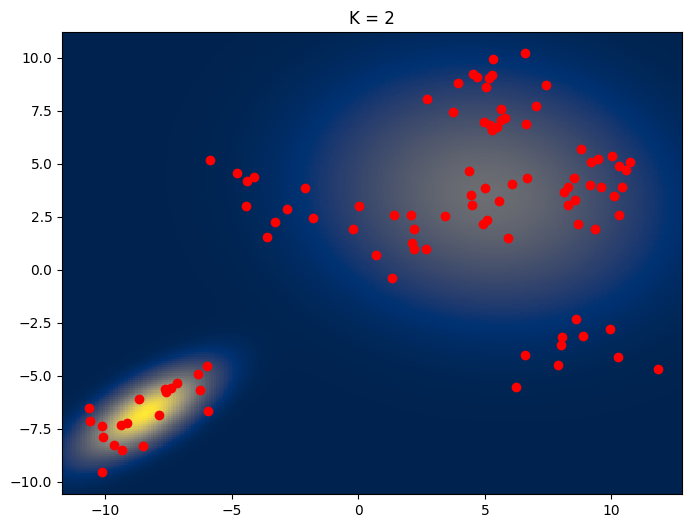

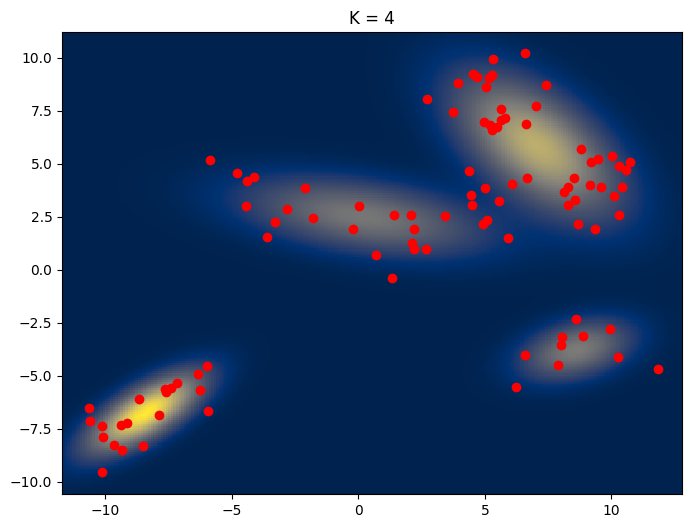

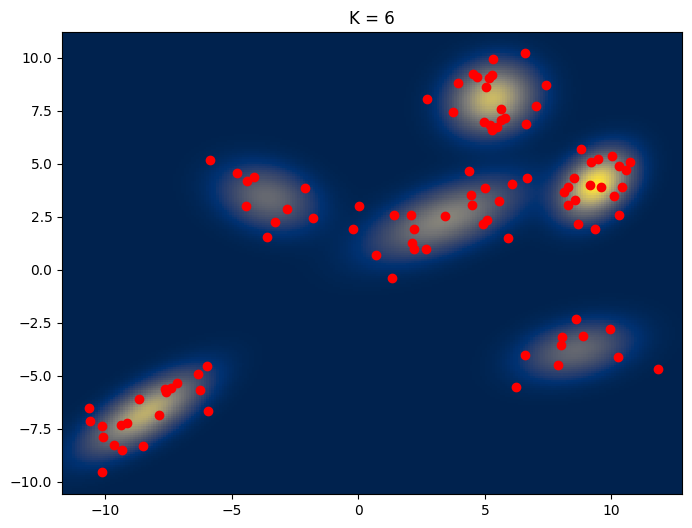

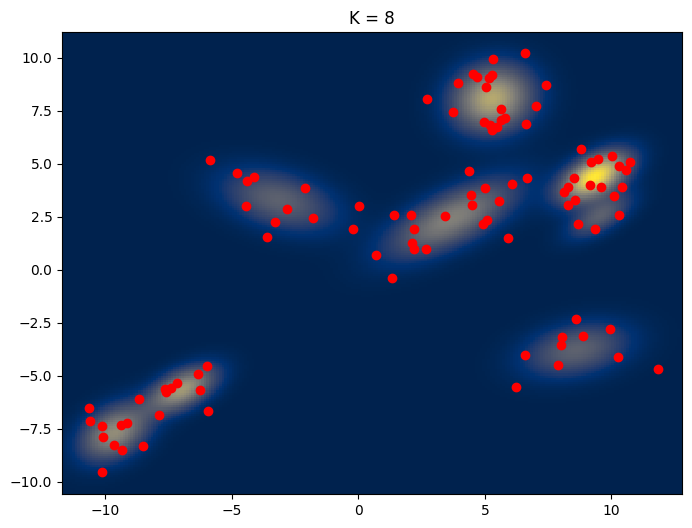

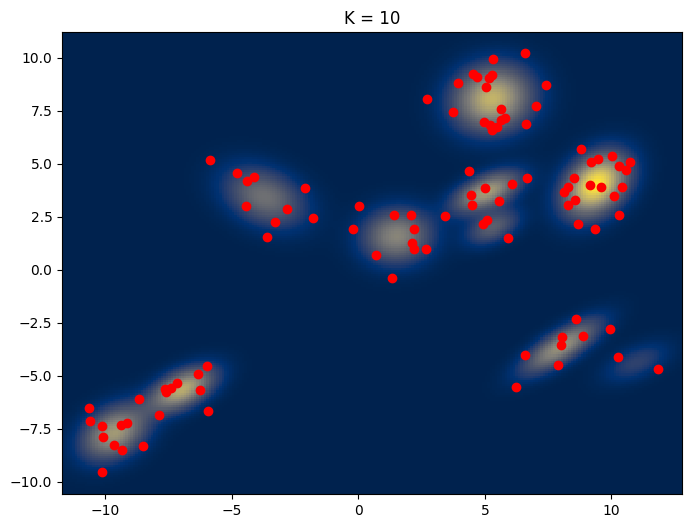

In [ ]:
for k in range(len(k_pedidos)):
  plt.figure(figsize=(8,6))
  back = plt.pcolormesh(x1, x2, valores[k], cmap = 'cividis')
  scatter = plt.scatter(df[:, 0], df[:, 1], color = 'red')
  plt.title("K =", k_pedidos[k])
  plt.show()